<a href="https://colab.research.google.com/github/yeoongin/iTshirt/blob/master/DL_model/KoBERT_%ED%83%9C%EA%B7%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 코랩 환경설정정
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers==3.0.2
!pip install torch
#깃허브에서 KoBERT 파일 로드
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook
#kobert
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

#transformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 28.1 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.5/344.5 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp39-cp39-linux_x86_64.whl size=680524 sha256=3d52b68932262b2b51576407c6b6471b6070ee32cd7cbc4072259cedbc76cc89
  Stored in directory: /root/.cache/pip/wheels/47/17/70/b257bc53879a458c4bfcc900e89271aa8b4f19366a54bd2455
Successfully built gluonnlp
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# GPU 사용
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#BERT 모델, Vocabulary 불러오기
bertmodel, vocab = get_pytorch_kobert_model()
bertmodel.to(device)

/content/.cache/kobert_v1.zip[██████████████████████████████████████████████████]
/content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece[██████████████████████████████████████████████████]


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(8002, 768, padding_idx=1)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )

In [ ]:
print(device)

cuda:0


In [ ]:
#구글드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 라벨링 파일 데이터 프레임 형태로 가져오기기
import pandas as pd
df = pd.read_excel('/content/drive/MyDrive/labeling_data.xlsx')

In [ ]:
# 10개의 데이터 랜덤으로 출력
df.sample(n=10)

,Unnamed: 0,sentences,tags,place,label
2373,2373,'태백산 눈꽃 축제'태백산 눈꽃 축제 다녀왔습니다. 태백산 눈꽃 축제장과 석탄박물관...,"#태백산, #태백겨울여행, #태백눈꽃축제, #겨울여행, #겨울여행지, #겨울여행지추...",NaN,2.0
1253,1253,여행다닐때 해식동굴 찾아다니는 묘미가 너무 좋다 밝게 찍어도 느낌있고 어둡게 찍어도...,"#당진왜목마을, #당진커플여행, #왜목마을해식동굴, #해식동굴인생사진, #해식동굴인...",왜목마을,2.0
2932,2932,:😴📍고창 선운사,NaN,고창,0.0
3141,3141,당첨자 발표할게요 ^^.유니크러블리.인스타그램 이벤트 10월 1일 시작했어요 당첨...,"#유니크러블리당첨자발표, #평택, #평택나들이, #핑크뮬리, #평택핑크뮬리, #평택...",NaN,1.0
365,365,: D.😘 😆♥ 😆대박.얍😊.😘: .,"#김해술집, #충주가볼만한곳, #부산대맛집추천, #함안맛집, #건대가볼만한곳, #화...",NaN,8.0
2649,2649,겨울을 보내기 아쉽게 오늘은 눈이 참 예쁘게 내렸습니다. 추운 날씨에도 방문해주신 ...,#컨츄리로드커피,컨츄리로드커피,9.0
2460,2460,여기는 영암 어디인가?상대포역사공원정자가 너무나 이쁘네요,"#상대포역사공원, #상대포, #구림전통마을, #영암도기박물관, #영암하정웅미술관, ...",NaN,1.0
2914,2914,오늘은 숙소에서 어디 안가고 죙일 놀자꾸나ㅎㅎ,"#게임현질, #풀빌라, #겨울여행, #통영, #통영여행, #통영겨울여행, #겨울여행...",NaN,2.0
1040,1040,해가나니 후덥지근하구만장마시작요란히 지내고 잠시 휴식,"#장마, #극락조, #창가, #후덥지근, #보리수펜션, #부산, #데일리, #하루,...",NaN,1.0
145,145,🍓대구 성심교회에서 방문🍓오늘 대구 성심교회에서 저희 농원을 방문해주셨습니다! 교회...,NaN,다산딸기조합농원,NaN


In [ ]:
# label 열의 값 float-> str
df['label'] = df['label'].astype(str)

In [ ]:
df.dtypes

Unnamed: 0     int64
sentences     object
tags          object
place         object
label         object
dtype: object

In [ ]:
# label 분류 숫자로 변경경
df.loc[(df['label'] == "0.0"), 'label'] = 0  #0.0 => 스팸 => 0
df.loc[(df['label'] == "1.0"), 'label'] = 1  #1.0 => 가볼만한곳 => 1
df.loc[(df['label'] == "2.0"), 'label'] = 2  #2.0 => 가족여행 => 2
df.loc[(df['label'] == "3.0"), 'label'] = 3  #3.0 => 관람 => 3
df.loc[(df['label'] == "4.0"), 'label'] = 4  #4.0 => 맛집 => 4
df.loc[(df['label'] == "5.0"), 'label'] = 5  #5.0 => 우정여행 => 5
df.loc[(df['label'] == "6.0"), 'label'] = 6  #6.0 => 전통 => 6
df.loc[(df['label'] == "7.0"), 'label'] = 7  #7.0 => 체험 => 7
df.loc[(df['label'] == "8.0"), 'label'] = 8  #8.0 => 카페 => 8
df.loc[(df['label'] == "9.0"), 'label'] = 9  #9.0 => 캠핑핑 => 9

<Axes: >

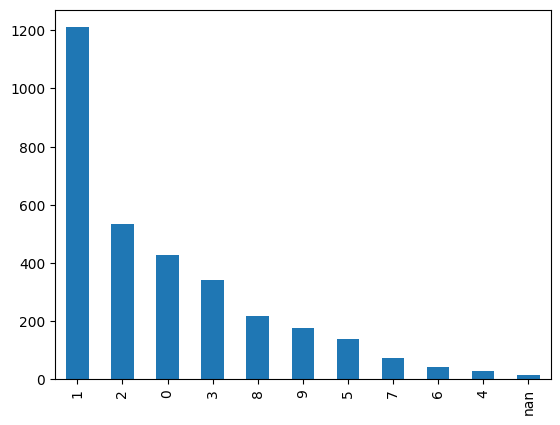

In [ ]:
# 데이터 정제하기
# label 값 분포 확인인
df['label'].value_counts().plot(kind = 'bar')

#실험
# df = df[df['label'] != 1]
# df = df[df['label'] != 2]

In [ ]:
df['label'].value_counts()

1      1211
2       533
0       427
3       341
8       217
9       175
5       138
7        74
6        43
4        28
nan      13
Name: label, dtype: int64

In [ ]:
len(df)

3200

In [ ]:
# Null 값 유무 확인 True <- Null 값 있음음
print(df.isnull().values.any())

True


In [ ]:

# 어떤 열에서 Null 값 존재하는지 확인
print(df.isnull().sum())

Unnamed: 0       0
sentences        1
tags           301
place         2005
label            0
dtype: int64


In [ ]:
# Null 값 많은 place 열 제거거
df = df.drop('place',axis=1)

In [ ]:
# 데이터 확인인
df

,Unnamed: 0,sentences,tags,label
0,0,NaN,#데이트립,0
1,1,강남 직장인을 위한 맛집 8곳을 추천해 드립니다. 방송에도 여러 번 소개된 곳부터 ...,NaN,0
2,2,술이 달다 !!라고 하는걸 이걸보구 말하나봐요알쓰들도 무한대로 마실수 있는 연말을 ...,"#선릉, #평상술집, #술, #술집, #술안주, #꿀주, #꿀막걸리, #막걸리, #...",8
3,3,•,"#강남카페, #강남대형카페도심, #카즐_서울, #카즐_강남, #카즐_가로수길, #카...",1
4,4,•,"#강남카페, #강남대형카페도심, #카즐_서울, #카즐_강남, #카즐_가로수길, #카...",2
...,...,...,...,...
3195,3195,이제..정말 봄이네요~~~^^ 여기 저기 꽃이 만발하니...어린아이들부터 어르신들까...,"#24게스트하우스인호텔, #순천게스트하우스추천, #순천게스트하우스, #순천24게스트...",2
3196,3196,이제..정말 봄이네요~~~^^ 여기 저기 꽃이 만발하니...어린아이들부터 어르신들까...,"#24게스트하우스인호텔, #순천게스트하우스추천, #순천게스트하우스, #순천24게스트...",5
3197,3197,이제..정말 봄이네요~~~^^ 여기 저기 꽃이 만발하니...어린아이들부터 어르신들까...,"#24게스트하우스인호텔, #순천게스트하우스추천, #순천게스트하우스, #순천24게스트...",7
3198,3198,"-배꽃피어나는 날에..벚꽃, 매화만큼이나 예쁜 배꽃이 피고있어요","#낙안민속촌, #배, #순천, #낙안, #배꽃, #천국, #여행, #사진, #순천가...",1


In [ ]:
# 어떤 열에서 Null 값 존재하는지 확인
print(df.isnull().sum())

Unnamed: 0      0
sentences       1
tags          301
label           0
dtype: int64


In [ ]:
# Null값 제거
df = df.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(df.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [ ]:
# Null값 제거 후 데이터 개수 확인인
print(len(df))

2898


In [ ]:
# data_list에 본문과 라벨링된 값 저장장
data_list = []
for q, label in zip(df['tags'], df['label'])  :
    if q.strip() == '' or q.strip() == '.':
        print(q)
        continue
    data = []
    data.append(q)
    data.append(str(label))

    data_list.append(data)

In [ ]:
print(data_list[0])
print(data_list[500])
#print(data_list[1200])
# print(data_list[1800])
# print(data_list[2400])
# print(data_list[2800])
# print(data_list[-1])

['#선릉, #평상술집, #술, #술집, #술안주, #꿀주, #꿀막걸리, #막걸리, #선릉맛집, #선릉술집, #강남술집', '8']
['#청농원, #느리지만소중하게, #예은여행, #고창여행, #고창카페, #고창청농원핑크뮬리', '2']


In [ ]:
#train & test 데이터로 나누기 train 80 test 20
from sklearn.model_selection import train_test_split
                                                         
dataset_train, dataset_test = train_test_split(data_list, test_size=0.2, random_state=0)

In [ ]:
# train data, test data 개수 확인인
print(len(dataset_train))
print(len(dataset_test))

2318
580


In [ ]:
# 각 데이터가 KoBERT 모델의 입력에 들어갈 수 있는 형태가 되도록
# 토큰화, 정수 인코딩, 패딩 필요
# 토큰화를 위한 클래스 정의의 
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = []
        #위 부분에서 label의 nan값은 건너뛰게 수정
        for i in dataset:
            if i[label_idx] != 'nan':
                self.labels.append(np.int32(i[label_idx]))

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [ ]:
# 하이퍼 파라미터 정의
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [ ]:
#토큰화 & 패딩 
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~ 위 에러 해결 후 아래 셀 실시 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [ ]:
# 토큰화 패딩 잘 이루어졌는지 확인
# 패딩된 시퀀스, 길이와 타임에 대한 내용, 어텐션 마스크 시퀀스스
data_train[0]

(array([   2,  517,    9,  862, 7402,  517,   46,  517,    9,  862, 7402,
        6925,  517,   46,  517,    9,  862, 7402, 5330, 6386, 6150, 7828,
        5451,  517,   46,  517,    9,  862, 7402, 5944, 6516, 7533, 6664,
         517,   46,  517,    9,  862, 7402, 5330, 7088, 6925,  517,   46,
         517,    9, 1585, 7750, 6204, 6607,  517,   46,  517,    9,  862,
        7402, 5788, 7750, 6204, 6607,  517,   46,  517,    3], dtype=int32),
 array(64, dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=int32),
 5)

In [ ]:
# torch형식의 dataset 만들기기
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

In [ ]:
# KoBERT 모델
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=10,   ## 10개 분류
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        token_ids = token_ids.to(device)
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [ ]:
# BERT 모델 불러오기
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

# optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

# 정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc
    
train_dataloader

In [ ]:
# KoBERT 모델 학습
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

<ipython-input-32-1803b6aa9ec1>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 2.436938524246216 train acc 0.03125
epoch 1 train acc 0.3581081081081081


<ipython-input-32-1803b6aa9ec1>:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 1 test acc 0.4083333333333333


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 2.1509833335876465 train acc 0.265625
epoch 2 train acc 0.39484797297297297


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 2 test acc 0.4083333333333333


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 2.097600221633911 train acc 0.296875
epoch 3 train acc 0.40033783783783783


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 3 test acc 0.4083333333333333


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 2.121318817138672 train acc 0.265625
epoch 4 train acc 0.40033783783783783


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 4 test acc 0.4083333333333333


  0%|          | 0/37 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 2.101304292678833 train acc 0.28125
epoch 5 train acc 0.40033783783783783


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 5 test acc 0.4083333333333333


In [ ]:
#토큰화
tokenizer = get_tokenizer()

tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [ ]:
import numpy as np
from scipy.special import softmax

def predict(predict_sentence):
    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)

    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)

        test_eval=[]
        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()

            # logits을 확률로 변환 (수정된 부분)
            probabilities = softmax(logits)
            probability_percent = probabilities * 100

            if np.argmax(logits) == 0:
                test_eval.append("스팸")
            elif np.argmax(logits) == 1:
                test_eval.append("가볼만한곳")
            elif np.argmax(logits) == 2:
                test_eval.append("가족여행")
            elif np.argmax(logits) == 3:
                test_eval.append("우정여행")
            elif np.argmax(logits) == 4:
                test_eval.append("전통")
            elif np.argmax(logits) == 5:
                test_eval.append("체험")
            elif np.argmax(logits) == 6:
                test_eval.append("캠핑")
            elif np.argmax(logits) == 7:
                test_eval.append("관람")
            elif np.argmax(logits) == 8:
                test_eval.append("맛집")
            elif np.argmax(logits) == 9:
                test_eval.append("카페")

            print(test_eval[0] + " 로 예측됩니다.")
            
             # logits을 확률로 변환
            probabilities = softmax(logits)
            probability_percent = probabilities * 100

            # 카테고리 레이블 및 인덱스
            category_labels = ["스팸", "가볼만한곳", "가족여행", "우정여행", "전통", "체험", "캠핑", "관람", "맛집", "카페"]

            # 가장 높은 확률을 가진 카테고리 출력
            predicted_label = np.argmax(logits)
            print(f"{category_labels[predicted_label]} 로 예측됩니다.")

            # 모든 카테고리에 대한 확률 출력
            for idx, label in enumerate(category_labels):
                print(f"{label}: {probability_percent[idx]:.2f}%")


In [ ]:
PATH = "model.pt"
torch.save(model.state_dict(), PATH)


In [ ]:
for data, answer in dataset_test:
  print('해시태그: '+data)
  predict(data)
  an = str(answer)
  print('정답: '+ an.replace('0','스팸').replace('1','가볼만한곳').replace('2','가족여행').replace('3','우정여행').replace('4','전통').replace('5','체험').replace('6','캠핑').replace('7','관람').replace('8','맛집').replace('9','카페'))
  print('---------------------------------------------------------------------------------------------------------------------------------------------------------------------------')

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
관람: 2.37%
맛집: 7.04%
카페: 5.31%
정답: 스팸
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------
해시태그: #강원도고성, #고성겨울여행, #진부령설경, #진부령폭설, #진부령고개
가볼만한곳 로 예측됩니다.
가볼만한곳 로 예측됩니다.
스팸: 9.37%
가볼만한곳: 40.23%
가족여행: 17.78%
우정여행: 11.12%
전통: 1.24%
체험: 4.29%
캠핑: 1.56%
관람: 2.31%
맛집: 6.91%
카페: 5.19%
정답: 가볼만한곳
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------
해시태그: #추울땐더추운곳으로, #시원하게막국수한그릇, #막국수는겨울이제맛, #삼합수육, #칡메밀전, #물막국수, #세일막국수, #동해맛집, #동해로컬맛집, #강원도, #동해, #동해겨울여행, #동해투어, #동해여행, #동해스타그램, #여행스타그램, #겨울스타그램
가볼만한곳 로 예측됩니다.
가볼만한곳 로 예측됩니다.
스팸: 9.28%
가볼만한곳: 40.85%
가족여행: 17.65%
우정여행: 11.07%
전통: 1.23%
체험: 4.23%
캠핑: 1.55%
관람: 2.28%
맛집: 6.79%
카페: 5.07%
정답: 맛집
--------------------------------------------------------------------------------------------